In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
from statsmodels.stats.multitest import multipletests

from utils.load_data_for_eda import load_data

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
df = load_data('data/commodity_prices.csv')
df.describe(include='all')

,Product_Type,Commodity,Variety_Type,Arrival_Date,Market,Is_VFPCK,Season,Year,Modal_Price,Max_Price,Min_Price
count,166028,166028,166028,166028,166028,166028,166028,166028.000000,166028.000000,166028.000000,166028.000000
unique,116,55,105,NaN,27,2,4,NaN,NaN,NaN,NaN
top,Ashgourd|Ashgourd|FAQ,Banana,Banana|Palayamthodan,NaN,Perumbavoor,False,Southwest Monsoon,NaN,NaN,NaN,NaN
freq,5166,17035,5954,NaN,22123,141329,51555,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,2024-08-09 13:25:38.892235008,NaN,NaN,NaN,2024.121353,5247.525315,5892.604639,4707.825763
min,NaN,NaN,NaN,2023-06-01 00:00:00,NaN,NaN,NaN,2023.000000,300.000000,0.000000,0.000000
25%,NaN,NaN,NaN,2024-02-05 00:00:00,NaN,NaN,NaN,2024.000000,3000.000000,3500.000000,2500.000000
50%,NaN,NaN,NaN,2024-08-20 00:00:00,NaN,NaN,NaN,2024.000000,4200.000000,5000.000000,3800.000000
75%,NaN,NaN,NaN,2025-02-23 00:00:00,NaN,NaN,NaN,2025.000000,5700.000000,6400.000000,5000.000000
max,NaN,NaN,NaN,2025-08-18 00:00:00,NaN,NaN,NaN,2025.000000,90000.000000,110000.000000,75000.000000


Seasonal Effect on Price

In [3]:
anova_results = {}

for product_type, group in df.groupby('Product_Type'):
    seasonal_groups = [seasonal_group['Modal_Price'].values for name, seasonal_group in group.groupby('Season')]
    seasonal_groups = [arr for arr in seasonal_groups if arr.std() > 0]
    
    if len(seasonal_groups) >= 2:
        stat, pval = f_oneway(*seasonal_groups)
        anova_results[product_type] = {'F-statistic': stat, 'p-value': pval}
    else: 
        continue

# Convert to DataFrame for sorting/filtering
anova_df = pd.DataFrame(anova_results).T.reset_index().rename(columns={'index': 'Product_Type'})

anova_df = anova_df.sort_values(by='p-value', ascending=True).reset_index(drop=True)
anova_df.head(10)

,Product_Type,F-statistic,p-value
0,Drumstick|Drumstick|FAQ,740.078779,0.000000e+00
1,Ashgourd|Ashgourd|FAQ,672.884547,0.000000e+00
2,Onion|Big|FAQ,561.238630,5.204789e-291
3,Green Chilli|Green Chilly|FAQ,520.872348,4.627220e-278
4,Mango (Raw-Ripe)|Mango - Raw-Ripe|FAQ,502.608828,1.451589e-257
5,Banana|Palayamthodan|Large,388.413965,7.489628e-217
6,Bitter gourd|Bitter Gourd|FAQ,363.326266,5.799831e-209
7,Banana|Nendra Bale|Large,323.671476,5.213477e-192
8,Tomato|Tomato|FAQ,292.476120,1.393565e-162
9,Carrot|Carrot|FAQ,184.842655,4.596799e-111


Most commodities (>90%) show strong seasonal price variation.
High seasonal impact: Banana (Nendra Bale, Green), Ashgourd, Ginger (Green), Bitter Gourd, Drumstick, Onion (Big).
Low/no seasonal effect: Amaranthus, Cowpea (Bean Barbati), Papaya (Raw), Onion (1st Sort Non-FAQ).
Borderline: French Beans, Water Melon, Amaranthus (Other).
Seasonal swings align with crop perishability and harvest timing.

In [6]:
# Boolean flag: at least one record in VFPCK
vfpck_flag = (
    df.groupby('Product_Type')['Is_VFPCK']
      .any()
      .reset_index()
      .rename(columns={'Is_VFPCK': 'Has_VFPCK'})
)

# Fraction of records in VFPCK
vfpck_stats = (
    df.groupby('Product_Type')['Is_VFPCK']
      .mean()
      .reset_index()
      .rename(columns={'Is_VFPCK': 'Pct_VFPCK'})
)

# Merge both into ANOVA table
vfpck_df = anova_df.merge(vfpck_stats, on='Product_Type', how='left')
vfpck_df = vfpck_df.merge(vfpck_flag, on='Product_Type', how='left')

# Keep only products that have VFPCK presence
vfpck_df = vfpck_df[vfpck_df['Has_VFPCK'] == True]

# Sort if needed
vfpck_df = vfpck_df.sort_values('Pct_VFPCK', ascending=False).reset_index(drop=True)

# Display the final DataFrame
vfpck_df.head(10)

,Product_Type,F-statistic,p-value,Pct_VFPCK,Has_VFPCK
0,Banana|Nendra Bale|Medium,0.000003,9.986209e-01,1.000000,True
1,Papaya|Other|Large,209.734322,8.316692e-95,1.000000,True
2,Banana|Robusta|Medium,12.401075,1.544887e-05,1.000000,True
3,Pineapple|Other|Small,29.093374,2.073386e-17,1.000000,True
4,Banana|Robusta|Large,46.612930,3.607105e-29,1.000000,True
5,Banana|Nendra Bale|Large,323.671476,5.213477e-192,0.865049,True
6,Banana|Palayamthodan|Large,388.413965,7.489628e-217,0.815317,True
7,Banana|Poovan|Large,141.712494,2.568108e-85,0.813877,True
8,Papaya|Papaya|Large,23.459957,2.037139e-14,0.784496,True
9,Pineapple|Other|Large,74.815843,9.775584e-46,0.671924,True


“VFPCK’s work has increased market access for farmers, but our analysis shows seasonal price swings remain high — even for commodities where VFPCK has significant market share.
Given the perishability of these crops, full-season storage is unrealistic. Instead, investments in value addition, short-term cold chain, market diversification, and forward contracting could better stabilize farmer incomes.”

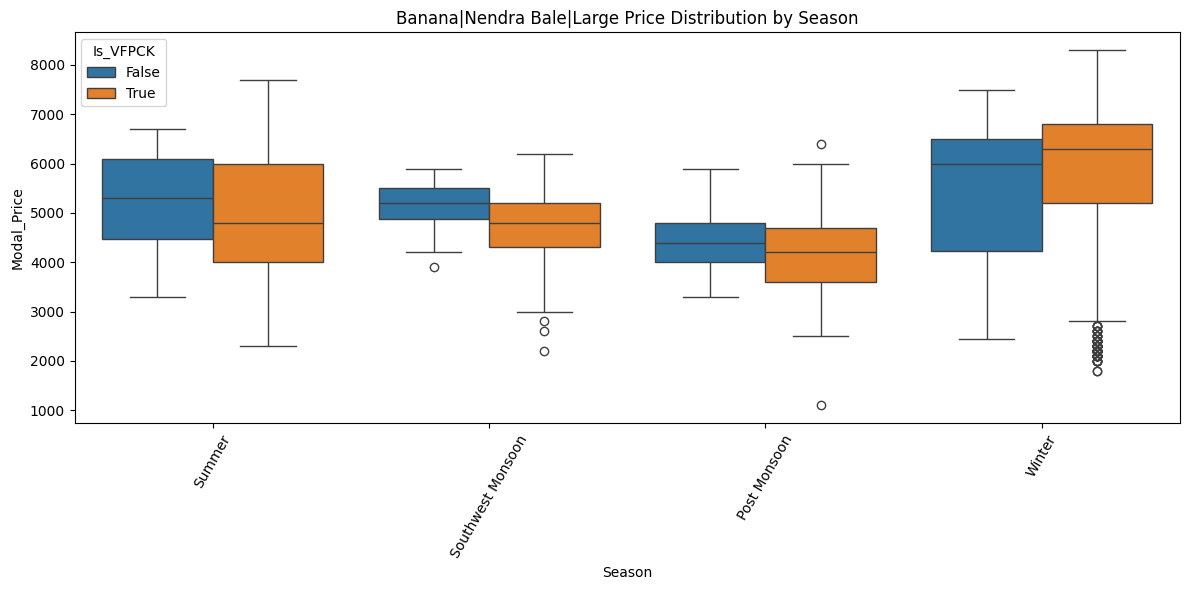

In [7]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(data=df[df['Product_Type'] == 'Banana|Nendra Bale|Large'], x='Season', y='Modal_Price', hue='Is_VFPCK',ax=ax)
ax.set_title('Banana|Nendra Bale|Large Price Distribution by Season')
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()

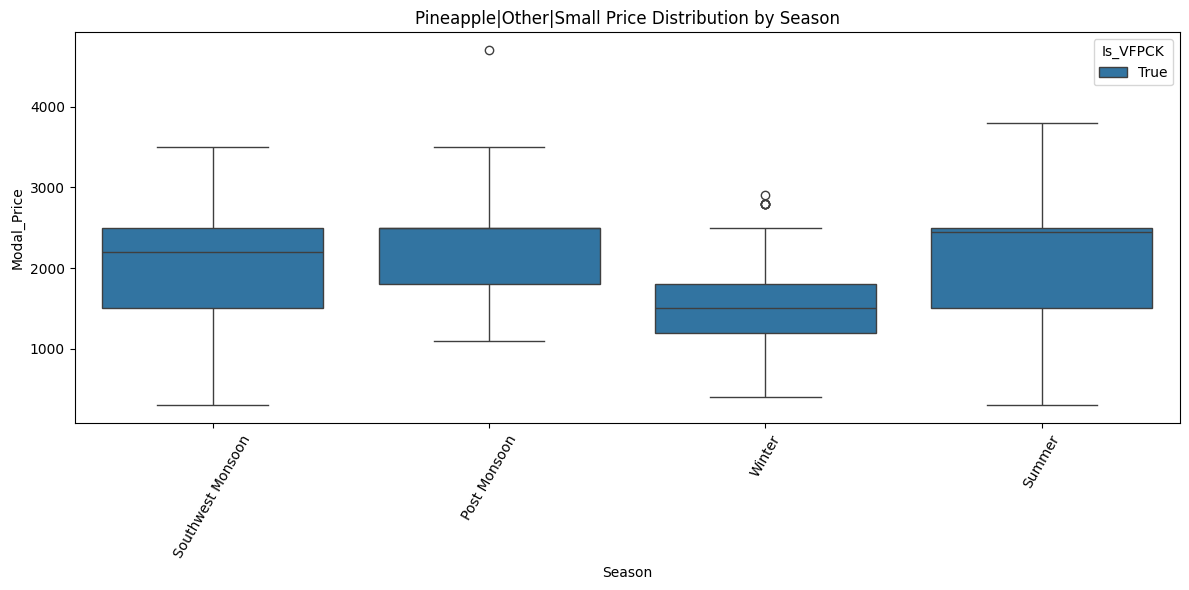

In [8]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(data=df[df['Product_Type'] == 'Pineapple|Other|Small'], x='Season', y='Modal_Price', hue='Is_VFPCK',ax=ax)
ax.set_title('Pineapple|Other|Small Price Distribution by Season')
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()

Yearly Effect

In [9]:
results = []
for (prod, market, season), group in df.groupby(['Product_Type', 'Market', 'Season']):
    if group['Year'].nunique() > 1:  # need at least 2 years
        samples = [grp['Modal_Price'].values for _, grp in group.groupby('Year')]
        
        # keep only groups with n>=2 and non-constant variance
        valid_samples = [s for s in samples if len(s) > 1 and s.std() > 0]
        
        if len(valid_samples) >= 2:
            stat, p = f_oneway(*valid_samples)
            results.append({
                'Product': prod,
                'Market': market,
                'Season': season,
                'F_stat': stat,
                'p_value': p
            })

results_df = pd.DataFrame(results)
results_df['reject'], results_df['p_adj'], _, _ = multipletests(
    results_df['p_value'], method='fdr_bh'
)

results_df['reject'].value_counts(normalize=True)


reject
True     0.799317
False    0.200683
Name: proportion, dtype: float64

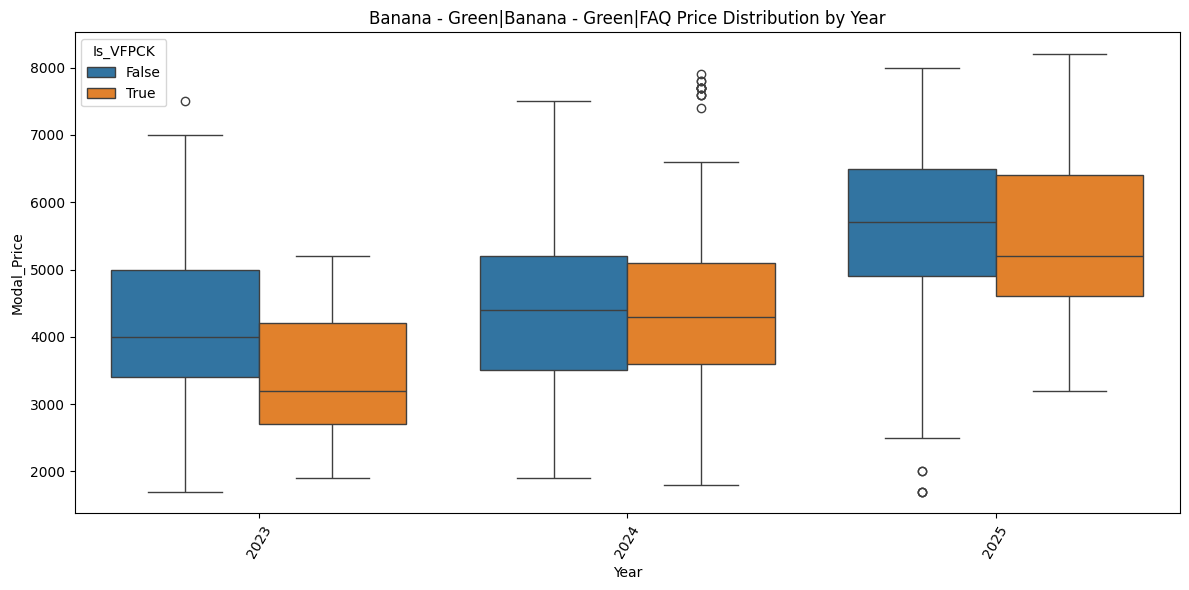

In [10]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(data=df[df['Product_Type'] == 'Banana - Green|Banana - Green|FAQ'], x='Year', y='Modal_Price', hue='Is_VFPCK', ax=ax)
ax.set_title('Banana - Green|Banana - Green|FAQ Price Distribution by Year')
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()

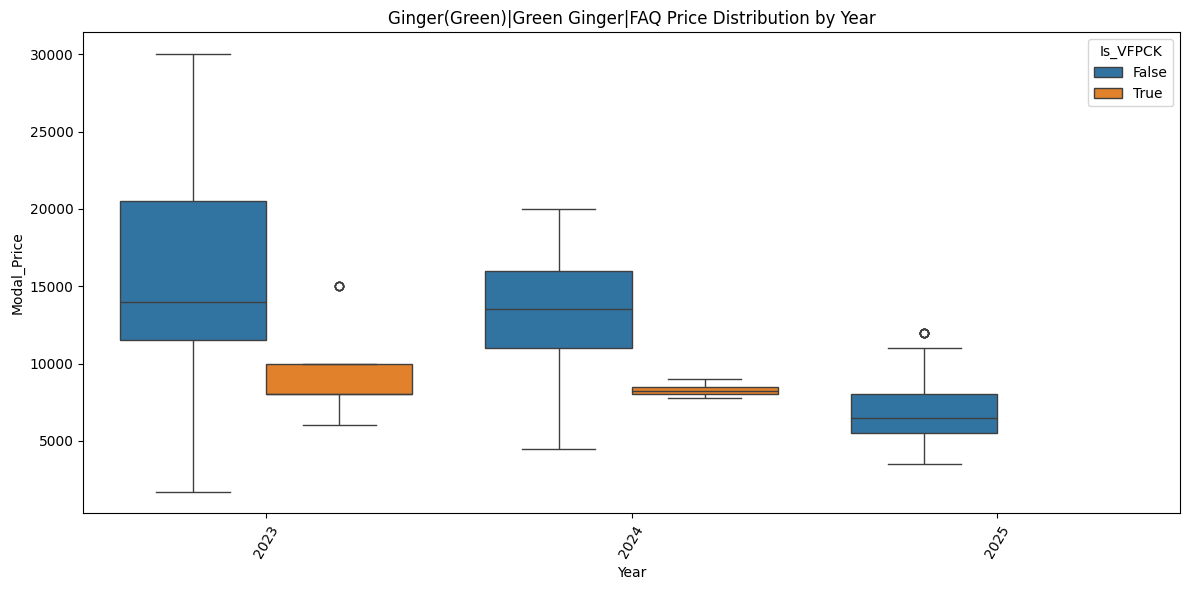

In [11]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(data=df[df['Product_Type'] == 'Ginger(Green)|Green Ginger|FAQ'], x='Year', y='Modal_Price', hue='Is_VFPCK', ax=ax)
ax.set_title('Ginger(Green)|Green Ginger|FAQ Price Distribution by Year')
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()

Market Effect

In [12]:
market_results = []

# Group by product + season + year (to keep things comparable)
for (prod, season, year), group in df.groupby(['Product_Type', 'Season', 'Year']):
    if group['Market'].nunique() > 1:  # at least 2 markets to compare
        samples = [grp['Modal_Price'].values for _, grp in group.groupby('Market')]
        
        # keep only valid distributions
        valid_samples = [s for s in samples if len(s) > 1 and s.std() > 0]
        
        if len(valid_samples) >= 2:
            stat, p = f_oneway(*valid_samples)
            market_results.append({
                'Product': prod,
                'Season': season,
                'Year': year,
                'F_stat': stat,
                'p_value': p
            })

market_df = pd.DataFrame(market_results)

# Multiple test correction
from statsmodels.stats.multitest import multipletests
market_df['reject'], market_df['p_adj'], _, _ = multipletests(
    market_df['p_value'], method='fdr_bh'
)

# Summary: how often market effect is significant
market_df['reject'].value_counts(normalize=True)

reject
True     0.934524
False    0.065476
Name: proportion, dtype: float64

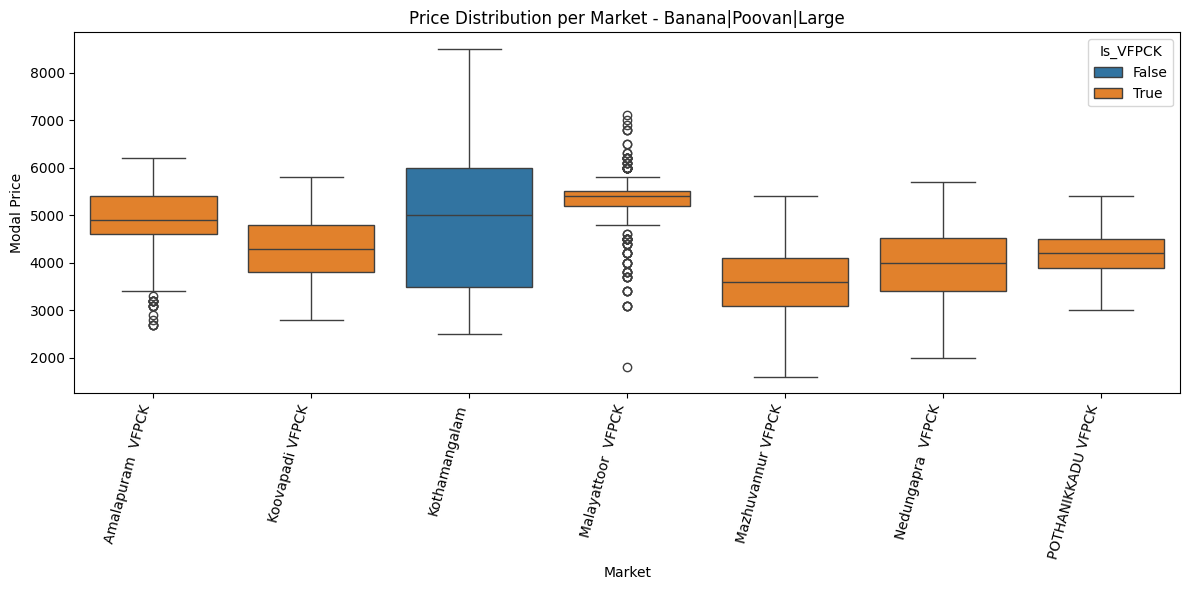

In [13]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df[df['Product_Type'] == 'Banana|Poovan|Large'], x='Market', y='Modal_Price', hue='Is_VFPCK')

plt.xticks(rotation=75, ha='right')
plt.title(f"Price Distribution per Market - Banana|Poovan|Large")
plt.ylabel("Modal Price")
plt.xlabel("Market")
plt.tight_layout()
plt.show()

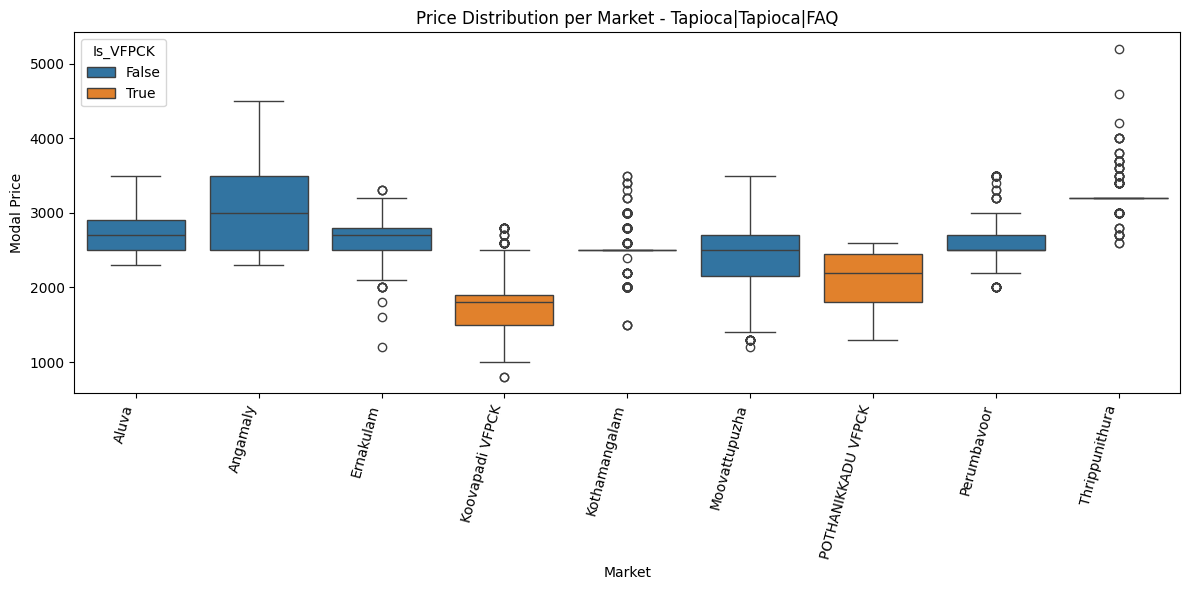

In [14]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df[df['Product_Type'] == 'Tapioca|Tapioca|FAQ'], x='Market', y='Modal_Price', hue='Is_VFPCK')

plt.xticks(rotation=75, ha='right')
plt.title(f"Price Distribution per Market - Tapioca|Tapioca|FAQ")
plt.ylabel("Modal Price")
plt.xlabel("Market")
plt.tight_layout()
plt.show()

Commodity Effect on Price


In [15]:
from scipy.stats import f_oneway

# Group all prices by commodity
commodity_groups = [grp['Modal_Price'].values for _, grp in df.groupby('Commodity')]

# Filter valid groups (need variance + enough samples)
valid_groups = [g for g in commodity_groups if len(g) > 1 and g.std() > 0]

if len(valid_groups) >= 2:
    stat, pval = f_oneway(*valid_groups)
    print("Commodity-level ANOVA: F =", stat, "p =", pval)
else:
    print("Not enough valid commodity groups for ANOVA")

Commodity-level ANOVA: F = 20908.489023962087 p = 0.0


Product_Type          Tomato|Deshi|FAQ  Tomato|Deshi|Non-FAQ  \
Product_Type                                                   
Tomato|Deshi|FAQ              1.000000              0.816353   
Tomato|Deshi|Non-FAQ          0.816353              1.000000   
Tomato|Other|FAQ              0.815456              0.633425   
Tomato|Tomato|FAQ             0.886692              0.880758   

Product_Type          Tomato|Other|FAQ  Tomato|Tomato|FAQ  
Product_Type                                               
Tomato|Deshi|FAQ              0.815456           0.886692  
Tomato|Deshi|Non-FAQ          0.633425           0.880758  
Tomato|Other|FAQ              1.000000           0.879118  
Tomato|Tomato|FAQ             0.879118           1.000000  


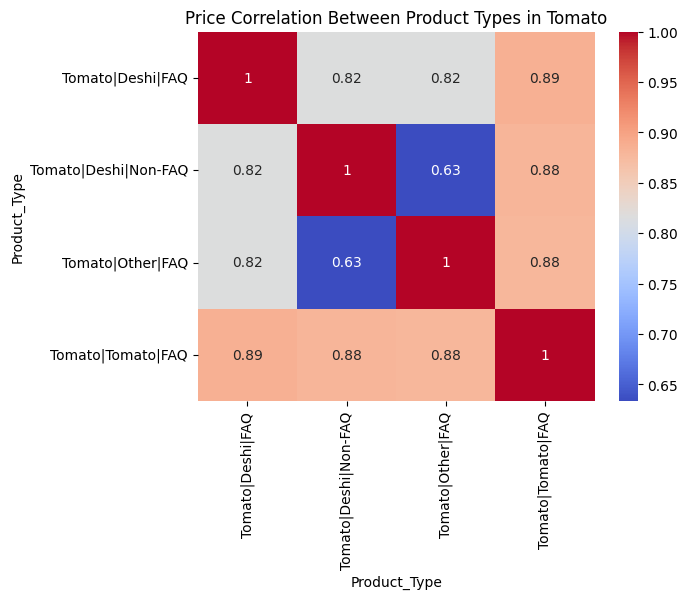

In [16]:
commodity = 'Tomato'  # example
df_commodity = df[df['Commodity'] == commodity]

price_pivot = df_commodity.pivot_table(
    index='Arrival_Date',
    columns='Product_Type',
    values='Modal_Price'
)
price_corr = price_pivot.corr()
print(price_corr)

import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(price_corr, annot=True, cmap='coolwarm')
plt.title(f'Price Correlation Between Product Types in {commodity}')
plt.show()

Product_Type                 Banana|Nendra Bale|Large  \
Product_Type                                            
Banana|Nendra Bale|Large                     1.000000   
Banana|Nendra Bale|Medium                    0.603173   
Banana|Other|Medium                          0.950828   
Banana|Palayamthodan|Large                   0.166843   
Banana|Palayamthodan|Medium                  0.114063   
Banana|Poovan|Large                          0.545875   
Banana|Poovan|Medium                         0.339153   
Banana|Robusta|Large                         0.465317   
Banana|Robusta|Medium                        0.475530   

Product_Type                 Banana|Nendra Bale|Medium  Banana|Other|Medium  \
Product_Type                                                                  
Banana|Nendra Bale|Large                      0.603173             0.950828   
Banana|Nendra Bale|Medium                     1.000000                  NaN   
Banana|Other|Medium                                NaN  

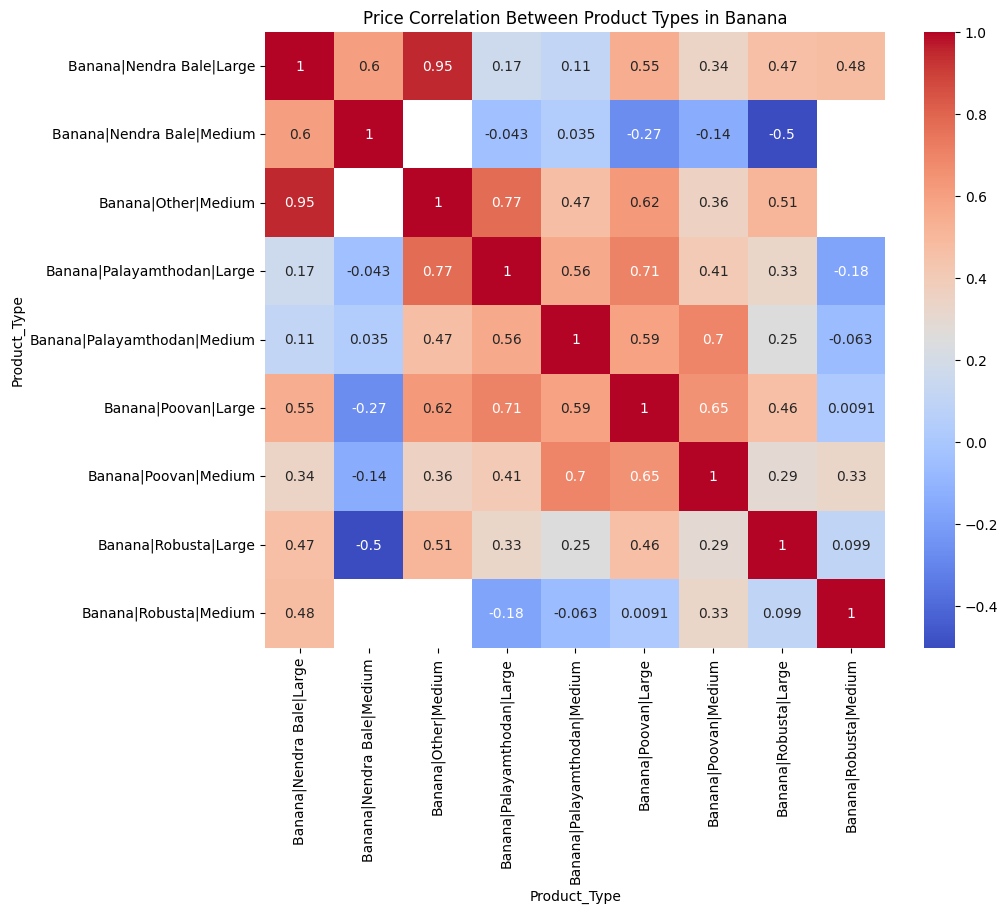

In [18]:
commodity = 'Banana'  # example
df_commodity = df[df['Commodity'] == commodity]

price_pivot = df_commodity.pivot_table(
    index='Arrival_Date',
    columns='Product_Type',
    values='Modal_Price'
)
price_corr = price_pivot.corr()
print(price_corr)

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
sns.heatmap(price_corr, annot=True, cmap='coolwarm')
plt.title(f'Price Correlation Between Product Types in {commodity}')
plt.show()

Product_Type                   Coconut Seed|Coconut Seed|FAQ  \
Product_Type                                                   
Coconut Seed|Coconut Seed|FAQ                       1.000000   
Coconut Seed|Other|FAQ                              0.944931   

Product_Type                   Coconut Seed|Other|FAQ  
Product_Type                                           
Coconut Seed|Coconut Seed|FAQ                0.944931  
Coconut Seed|Other|FAQ                       1.000000  


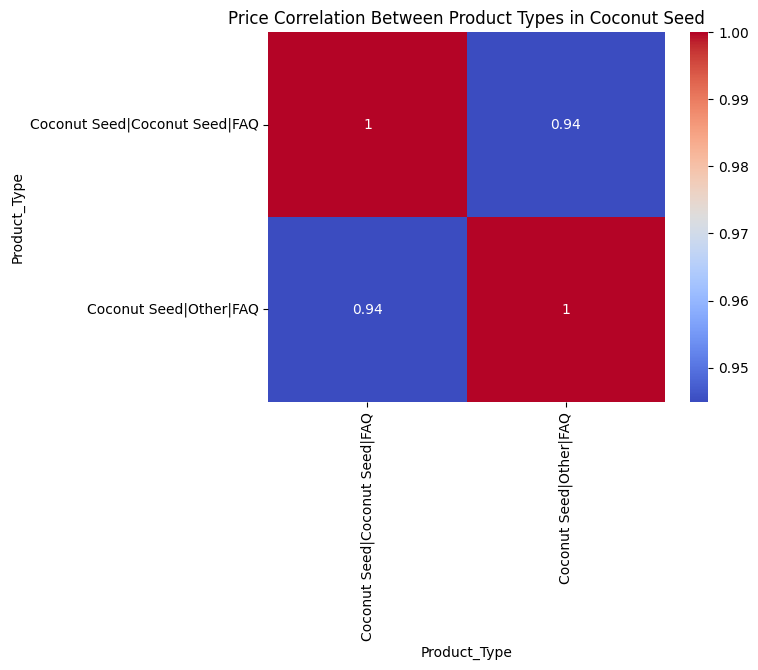

In [19]:
commodity = 'Coconut Seed'  # example
df_commodity = df[df['Commodity'] == commodity]

price_pivot = df_commodity.pivot_table(
    index='Arrival_Date',
    columns='Product_Type',
    values='Modal_Price'
)
price_corr = price_pivot.corr()
print(price_corr)

import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(price_corr, annot=True, cmap='coolwarm')
plt.title(f'Price Correlation Between Product Types in {commodity}')
plt.show()

Variety Type Effect on Price

In [20]:
from scipy.stats import f_oneway

# Group all prices by commodity
variety_groups = [grp['Modal_Price'].values for _, grp in df.groupby('Variety_Type')]

# Filter valid groups (need variance + enough samples)
valid_groups = [g for g in variety_groups if len(g) > 1 and g.std() > 0]

if len(valid_groups) >= 2:
    stat, pval = f_oneway(*valid_groups)
    print("Variety-level ANOVA: F =", stat, "p =", pval)
else:
    print("Not enough valid variety groups for ANOVA")

Variety-level ANOVA: F = 11517.226750945483 p = 0.0


Product_Type               Banana|Nendra Bale|Large  Banana|Nendra Bale|Medium
Product_Type                                                                  
Banana|Nendra Bale|Large                   1.000000                   0.603173
Banana|Nendra Bale|Medium                  0.603173                   1.000000


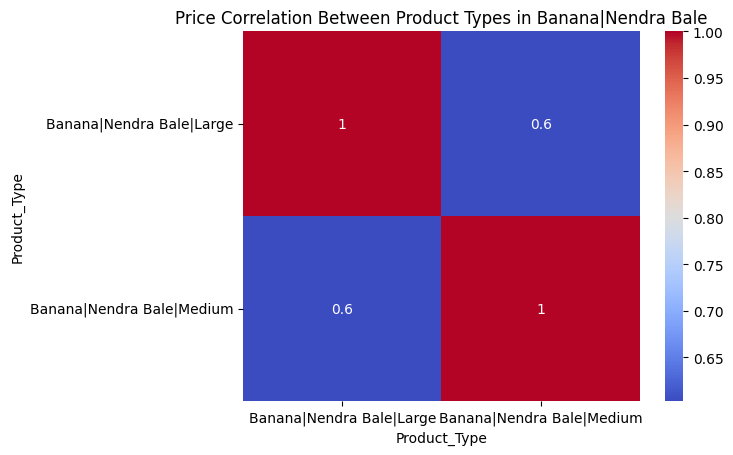

In [21]:
variety = 'Banana|Nendra Bale'  # example
df_variety = df[df['Variety_Type'] == variety]

price_pivot = df_variety.pivot_table(
    index='Arrival_Date',
    columns='Product_Type',
    values='Modal_Price'
)
price_corr = price_pivot.corr()
print(price_corr)

import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(price_corr, annot=True, cmap='coolwarm')
plt.title(f'Price Correlation Between Product Types in {variety}')
plt.show()

Product_Type                 Banana|Palayamthodan|Large  \
Product_Type                                              
Banana|Palayamthodan|Large                     1.000000   
Banana|Palayamthodan|Medium                    0.564592   

Product_Type                 Banana|Palayamthodan|Medium  
Product_Type                                              
Banana|Palayamthodan|Large                      0.564592  
Banana|Palayamthodan|Medium                     1.000000  


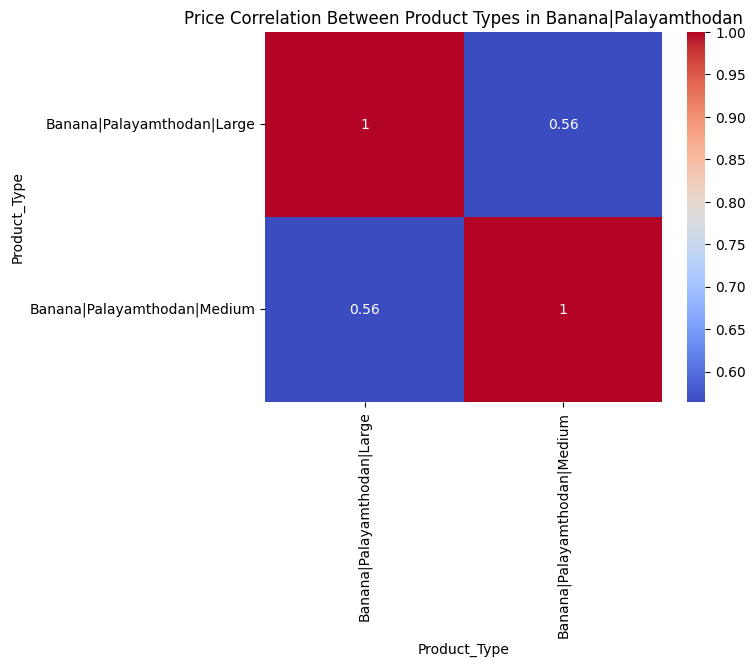

In [22]:
variety = 'Banana|Palayamthodan'  # example
df_variety = df[df['Variety_Type'] == variety]

price_pivot = df_variety.pivot_table(
    index='Arrival_Date',
    columns='Product_Type',
    values='Modal_Price'
)
price_corr = price_pivot.corr()
print(price_corr)

import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(price_corr, annot=True, cmap='coolwarm')
plt.title(f'Price Correlation Between Product Types in {variety}')
plt.show()